# Music Genre Classification
![from https://unsplash.com/photos/4Ixm9K6TbYg](https://images.unsplash.com/photo-1595598237436-bf64a3bf18cd?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=3870&q=80)

Photo from [Unsplash](https://unsplash.com/@atimagodie).

## Overview
### Training a Convolutional Neural Network using audio samples

We have been tasked with building a genre classifier for use in a playlist generator system. Our data is a 1000 song samples with a single label from a list of 10 genres. We processed these samples into a series of mel spectrograms, which were fed into a convolutional neural network. The output was which genre it believed the sample was most likely to belong to. We achieved 58% accuracy on a holdout set, and focused on precision scores for each genre. The model performed better for some genres than others. We recommend it inclusion within the playlist generator system. Even if it mis-classifies a song as a certain genre, it picks up on the major/important features that underly it. This would make the song a good fit for a playlist containing songs that are technically a different genre.

## Business Problem

Playlistly is an up and coming playlist-based music streaming service seeking to break into the industry and compete with Spotify. Playlists are the big way artists and songs get plays nowadays, so creating a service that is based around generating playlists that people will enjoy is a lucrative idea.

We have been contracted to build a component of their larger recommendation system—a genre classifier. The goal is to give the model a sample of a song and then have it accurately tag its genre. The model, therefore, will be useful for playlist generation, since genre is a high-level descriptor of what a song sounds like.

We should strive for a high level of accuracy—particularly from the view point of precision (of all predictions for a given genre, what portion is correct). 

In this data set, songs are given one label as ground truth for the model to learn from. However, in the real world genres are inherently difficult to define, songs can be hard to place into neatly-defined genres, many songs have multiple genres, and many genres share qualities/influences. With this in mind, recall (of all actual members of a genre, how many were correctly placed) would be a less-useful metric, since it depends on a properly-labeled ground truth, which may or may not be accurate.

Critically, the genre classifier does not have to be perfect. If the model can pick up on the major/important underlying patterns of the music, even if its label is incorrect, those songs will be similar enough that it will be acceptable for playlist building. In some contexts that may be preferable because it introduces a level of variety to a playlist. In short, an inaccurate genre classifier component won’t make for a bad playlist creation system. Furthermore, good practice for this system would include functionality for users to flag misplaced songs in playlists, so that even if a song is in the wrong place it can be addressed by the company. This effort is still drastically smaller than what would exist without even a subpar genre classifier.

## Data Understanding

The original dataset can be found at http://marsyas.info/downloads/datasets.html

The Dataset consists of 1000 songs evenly divided up onto 10 music genres: blues, rock, hiphop, classical, jazz, pop, disco, metal, reggae, country. These genres are the target.

The audio files are each 30 seconds long with a sample rate of 22050 Hz and bit depth of 16 bits. All the songs are in mono and in the .wav format. There was only one song that gave an encoding error and could not be import. The song in question was a Jazz song and it was removed from our dataset.

These samples are taken from various artists within each genre, and offer a decent range of what exists within each genre. However, this data is limited because there is yet a much broader range within each genre. Furthermore, there are many more genres that exist outside of the 10 included genres, and many songs exist within more than one genre. Lastly, 100 songs is definitely not enough to capture the full range of possibilities within each genre.

In [6]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import random
import json
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.random import set_seed
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *

import librosa, librosa.display

from functions import get_mels, create_min_max_scaler, evaluate

In [7]:
# load metadata csv
df = pd.read_csv('Data/features_30_sec.csv')

In [8]:
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  ...  mfcc19_var  mfcc20_mean  mfcc20_var  label
0  blues.00000.wav  661794          0.350088         0.088757  ...   55.062923     1.221291   46.936035  blues
1  blues.00001.wav  661794          0.340914         0.094980  ...   51.106190     0.531217   45.786282  blues
2  blues.00002.wav  661794          0.363637         0.085275  ...   46.639660    -2.231258   30.573025  blues
3  blues.00003.wav  661794          0.404785         0.093999  ...   37.259739    -3.407448   31.949339  blues
4  blues.00004.wav  661794          0.308526         0.087841  ...   62.910812   -11.703234   55.195160  blues

[5 rows x 60 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [10]:
# are the songs of equal length?
df['length'].unique()

array([661794, 669680, 661676, 665280, 661760, 663520, 661408, 661344,
       670120, 672282, 663080, 663300, 666820, 668800, 661100, 663740,
       664180, 666160, 668140, 667920, 665060, 661504, 664400, 669240,
       660000, 667700, 675808, 665940, 662112, 672100, 661980, 667480,
       661500, 670340, 669460], dtype=int64)

In [11]:
# what is the shortest song? number of samples/22,050 samples per second
df['length'].min()/22050

29.931972789115648

Each song is sampled at a rate of 22,050 Hz and is about 30 seconds long. There are about 661,500 samples per song as seen in the `length` column. We'll sample the first 29 seconds of each song at a later step for consistency.

There is quite a bit of metadata for each song, but we will focus on transforming the audio files into various "visual-like" representations. So, the relevant columns for us are the `filename` and `label`.

In [12]:
# select the relevant columns
df = df[['filename', 'label']]
df.head()

filename  label
0  blues.00000.wav  blues
1  blues.00001.wav  blues
2  blues.00002.wav  blues
3  blues.00003.wav  blues
4  blues.00004.wav  blues

In [13]:
# check class balance
df['label'].value_counts()

pop          100
classical    100
blues        100
country      100
hiphop       100
disco        100
rock         100
metal        100
jazz         100
reggae       100
Name: label, dtype: int64

The 1,000 songs are uniformly distributed across the 10 genres.

Next, let's transform the dataframe by creating a `file_path` column which contains the relative file path to each song.

In [14]:
# relative path to the directory of audio file genre subfolders
rel_path = 'Data/genres_original/'

# create relative path to each audio file
df['file_path'] = rel_path + df['label'] + '/' + df['filename']

# drop 'filename' column
df = df.drop(columns='filename')
df.head()

label                                   file_path
0  blues  Data/genres_original/blues/blues.00000.wav
1  blues  Data/genres_original/blues/blues.00001.wav
2  blues  Data/genres_original/blues/blues.00002.wav
3  blues  Data/genres_original/blues/blues.00003.wav
4  blues  Data/genres_original/blues/blues.00004.wav

There is one audio file which cannot be loaded, so it has been removed from the dataset. We'll drop it from our dataframe of file paths now.

In [15]:
# drop the corrupted song
df = df.drop(labels=554)

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      999 non-null    object
 1   file_path  999 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


Now, we'll transform the target into a vector suitable for incorporation into our model, followed by a split into train, test, and holdout sets.

In [16]:
# instantiate, fit, transform multiclass target
le = LabelEncoder()
y = le.fit_transform(df['label'])

# one hot encode multiclass target
output_shape = df['label'].nunique()
labels = le.classes_
y = keras.utils.to_categorical(y, output_shape)

# check shape
y.shape

(999, 10)

In [17]:
# split into a 10% holdout set
X_t, X_hold, y_t, y_hold = train_test_split(df['file_path'], y, random_state=42, stratify=y, test_size=0.1)

# split into 75% train, 15% test sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, random_state=42, stratify=y_t, test_size=15/90)

With some preliminary cleaning out of the way, it's time to do some data preparation and EDA.

## Data Preparation

### Waveforms

The audio files can be loaded into memory via the librosa library. Here is an example.

In [22]:
# jazz sample 506
y, sr = librosa.load(X_train[506], duration=29)

# take a listen
ipd.Audio(y, rate=sr)

 One way to visualize the song is as a waveform, or changes in air pressure over time. Below is an example for a jazz song.

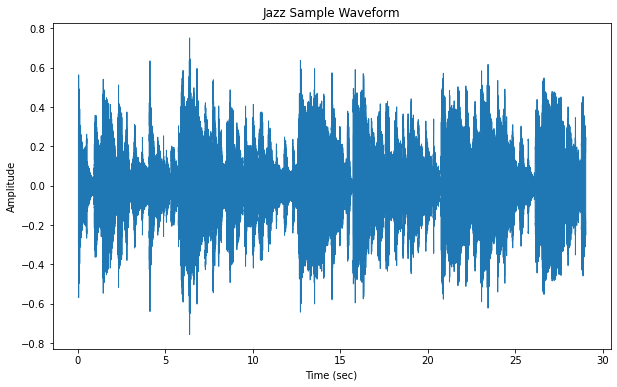

In [19]:
# visualize waveform
fig, ax = plt.subplots(figsize=(10,6))
librosa.display.waveshow(y, sr=sr, ax=ax);
ax.set(title='Jazz Sample Waveform', xlabel='Time (sec)', ylabel='Amplitude');

### Mel Spectrograms

The waveform, which is a representation of the audio signal in the time domain, can be transformed into a representation that shows composite frequencies. Specifically, we will use a librosa function to transform the signal into a mel spectrogram. The mel spectrogram shows changes in frequencies over time.

The frequencies are scaled logarithmically to the mel scale, which approximates human hearing in regards to pitch. The amplitude or loudness of each frequency is also scaled logarithmically to decibels (dB) to approximate human hearing in regards to loudness. The reasoning is that humans perceive sound in relative changes not absolute changes.

Below is the mel spectrogram for our jazz song.

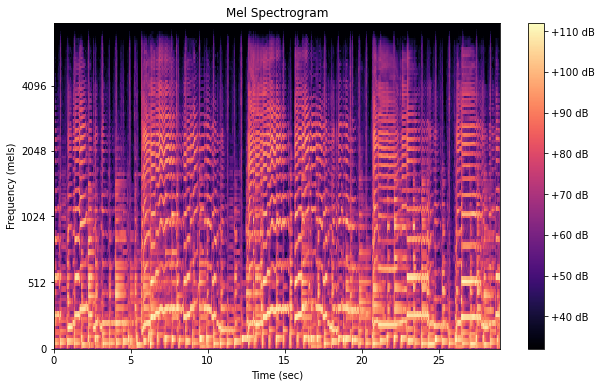

In [20]:
# mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)

# convert to dB for human loudness perception
S_dB = librosa.power_to_db(S, ref=np.min)

# visualize it
fig, ax = plt.subplots(figsize=(10,6))
S_dB_img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(S_dB_img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [21]:
S_dB.shape

(128, 1249)

The mel spectrogram is 128x1249. There are 128 mels and 1249 frames in the 29-second sample. Note that the amplitudes themselves, not the visual representation of pixels via the colormap, will be used as input for modeling.

Below, we'll generate mel spectrograms for our train, test, and holdout sets.

In [23]:
# generate mel spectrograms for train
X_train_mel = get_mels(X_train, 29)

# generate mel spectrograms for test
X_test_mel = get_mels(X_test, 29)

# generate mel spectrograms for holdout
X_hold_mel = get_mels(X_hold, 29)

# check shape
print(X_train_mel.shape, X_test_mel.shape, X_hold_mel.shape)

(749, 128, 1249, 1) (150, 128, 1249, 1) (100, 128, 1249, 1)


The input shape for the model will be (128, 1249, 1).

In [24]:
# define input shape
input_shape = X_train_mel.shape[1:]

Let's take a look at a spectrogram for each genre below.

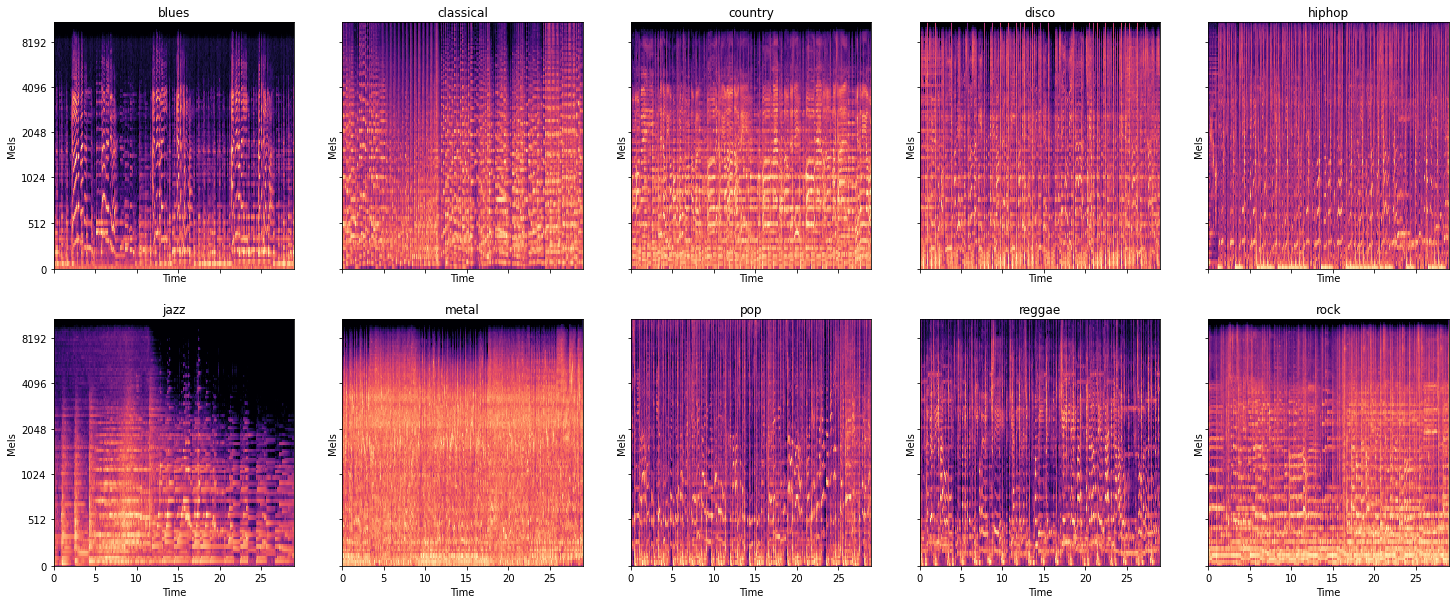

In [25]:
# visualize a spectrogram for each genre
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10), sharex=True, sharey=True)
ax = ax.ravel()

random.seed(999)

for i in range(0, 999, 100):
    # list of indices for each genre in X_train
    list_genre_ind = list(X_train[X_train.index.isin(range(i, i+100))].index)
    
    # random sample of one song for each genre
    genre_ind = random.sample(list_genre_ind, 1)[0]
    
    # convert this label index to positional index
    genre_pos_ind = X_train.index.get_loc(genre_ind)
    
    # visualize each spectrogram
    S_dB_img = librosa.display.specshow(X_train_mel[genre_pos_ind, :, :, 0],
                                        x_axis='time',
                                        y_axis='mel',
                                        ax=ax[int(i/100)])
    
    ax[int(i/100)].set(title=labels[int(i/100)], ylabel='Mels');

We can see some differences visually between genres. For example, metal has a wide range of frequencies at an elevated amplitude over the duration of the song, whereas other genres have narrower frequency ranges. Genres like disco and hiphop display something approximating high-tempo, regular beats.

A convolutional neural network may be able to pick up on something like these and other patterns.

Before modeling, we'll need one final preparation step. The mel spectrograms need to be scaled according to the training data. We'll normalize the data to be between 0 and 1.

In [26]:
# scale all the spectrograms based on train data
min_max_scaler = create_min_max_scaler(X_train_mel)

# apply the scaling to train, test, holdout sets
X_train_mel_scaled = min_max_scaler(X_train_mel)
X_test_mel_scaled = min_max_scaler(X_test_mel)
X_hold_mel_scaled = min_max_scaler(X_hold_mel)

In the next cell we will use a different method where we extract the Mel-Fequency Cepstral Coefficents (MFCC) which represent the overall shape of an audio signal. 
This method involves exporting the splitting each song into 10 segments and MFCC's of each song and their label will be exported to a JSON folder to keep ot serperate from the other dataframes used in this notebook. 

In [36]:
# Set a Path for the JSON dataframe
json_path = r"data.mfcc.json"
# bring in the audio dataframe path 
audio_file_path = '/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original'


# function to iterate through each audio file and convert to MFCC's and export new dataframe as JSON file. 


hop_length = 512
duration = 30        # length of song to be used (in seconds) 
n_mels=128           # number of Mel Filter Bins used
n_mfcc = 20 
n_fft = 2048
samples_per_track = sr * duration

def save_mfcc(dataset_path, json_path, n_mfcc=n_mfcc, n_fft=n_fft,
             hop_length=hop_length, num_segments=10):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(samples_per_track/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=22050)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        S = librosa.feature.melspectrogram(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    hop_length = hop_length, n_mels=n_mels)
                        
                        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))


                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            #print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)


In [37]:
# calling the function to create new JSON dataframe 
save_mfcc(audio_file_path,json_path)

Processing: pop
Processing: metal
Processing: disco
Processing: blues
Processing: reggae
Processing: classical
Processing: rock
Processing: hiphop
Processing: country
Processing: jazz


## Modeling and Evaluation

### Baseline Understanding

A baseline understanding prediction would be predicting the target class at the base rate of 10% for each class, and we would expect the prediction to be correct 10% of the time. In other words, the precision for each class would be expected to be 10%.

### First Model - Multilayer Perceptron

We'll start off with a multilayer perceptron.

In [27]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
mlp = keras.Sequential(name='mlp')

# flatten input 3D tensor to 1D
mlp.add(layers.Flatten(input_shape=input_shape))

# two hidden layers
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))

# output layer
mlp.add(layers.Dense(10, activation='softmax'))

# compile cnn
mlp.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
mlp.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 159872)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               20463744  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 20,472,650
Trainable params: 20,472,650
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit the model
history = mlp.fit(X_train_mel_scaled,
                  y_train,
                  epochs=60,
                  batch_size=30,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/60
25/25 [==============================] - 2s 88ms/step - loss: 23.6212 - accuracy: 0.0854 - val_loss: 7.1462 - val_accuracy: 0.1000
Epoch 2/60
25/25 [==============================] - 2s 83ms/step - loss: 5.3787 - accuracy: 0.1242 - val_loss: 2.6332 - val_accuracy: 0.1933
Epoch 3/60
25/25 [==============================] - 2s 82ms/step - loss: 4.3595 - accuracy: 0.1629 - val_loss: 2.3660 - val_accuracy: 0.1933
Epoch 4/60
25/25 [==============================] - 2s 82ms/step - loss: 2.8154 - accuracy: 0.1789 - val_loss: 2.6855 - val_accuracy: 0.1667
Epoch 5/60
25/25 [==============================] - 2s 83ms/step - loss: 2.5876 - accuracy: 0.2216 - val_loss: 2.9265 - val_accuracy: 0.1467
Epoch 6/60
25/25 [==============================] - 2s 82ms/step - loss: 2.4704 - accuracy: 0.2150 - val_loss: 2.3353 - val_accuracy: 0.2267
Epoch 7/60
25/25 [==============================] - 2s 86ms/step - loss: 2.0939 - accuracy: 0.2510 - val_loss: 2.1785 - val_accuracy: 0.2600
Epoch 8/60
2

Epoch 59/60
25/25 [==============================] - 2s 83ms/step - loss: 1.0306 - accuracy: 0.6555 - val_loss: 1.6159 - val_accuracy: 0.3400
Epoch 60/60
25/25 [==============================] - 2s 80ms/step - loss: 1.1556 - accuracy: 0.5741 - val_loss: 1.9213 - val_accuracy: 0.3400


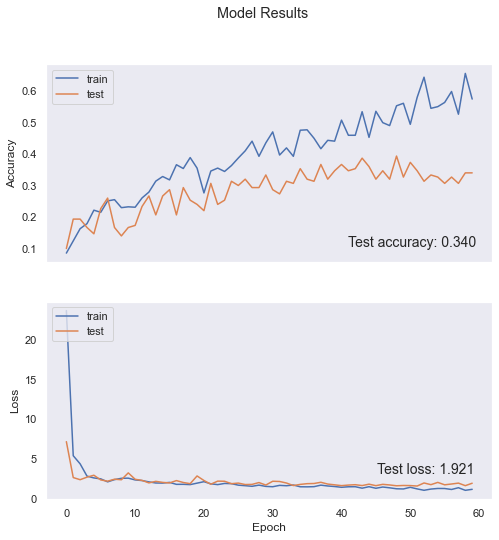

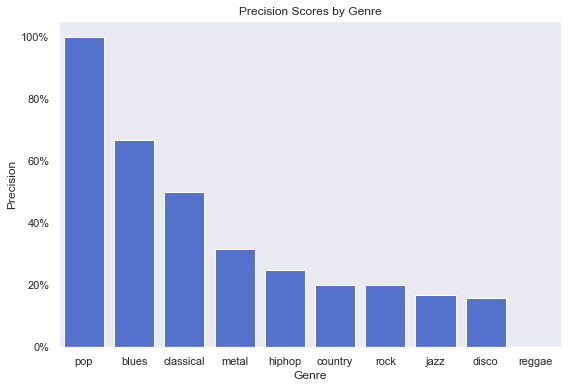

In [29]:
# visualize results and return predictions
mlp_results = evaluate(mlp, history, X_test_mel_scaled, y_test, labels)

This model achieves 34% accuracy on the test set, which the model is not trained on. There are signs of overfitting based off the accuracy chart, but the loss is relatively stable for both. We believe a CNN will better capture the patterns in the mel spectrograms, so that will be our next iteration.

### Modeling Iterations - CNN

In [261]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn = keras.Sequential(name='cnn_1')

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 4)))

cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))

cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 1249, 16)     160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 312, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 312, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 78, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 39, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 39, 128)       73856 

In [262]:
# fit the model
history = cnn.fit(X_train_mel_scaled,
                  y_train,
                  epochs=40,
                  batch_size=30,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/40
25/25 [==============================] - 26s 1s/step - loss: 2.3084 - accuracy: 0.1362 - val_loss: 2.2666 - val_accuracy: 0.1733
Epoch 2/40
25/25 [==============================] - 20s 792ms/step - loss: 2.2475 - accuracy: 0.1615 - val_loss: 2.1835 - val_accuracy: 0.2267
Epoch 3/40
25/25 [==============================] - 18s 715ms/step - loss: 2.1326 - accuracy: 0.2256 - val_loss: 2.0042 - val_accuracy: 0.3200
Epoch 4/40
25/25 [==============================] - 18s 730ms/step - loss: 2.0135 - accuracy: 0.2603 - val_loss: 1.8551 - val_accuracy: 0.3000
Epoch 5/40
25/25 [==============================] - 18s 737ms/step - loss: 1.8616 - accuracy: 0.3097 - val_loss: 1.8388 - val_accuracy: 0.3400
Epoch 6/40
25/25 [==============================] - 18s 734ms/step - loss: 1.6826 - accuracy: 0.3765 - val_loss: 1.5489 - val_accuracy: 0.4000
Epoch 7/40
25/25 [==============================] - 18s 740ms/step - loss: 1.5403 - accuracy: 0.3979 - val_loss: 1.4334 - val_accuracy: 0.4667
Ep

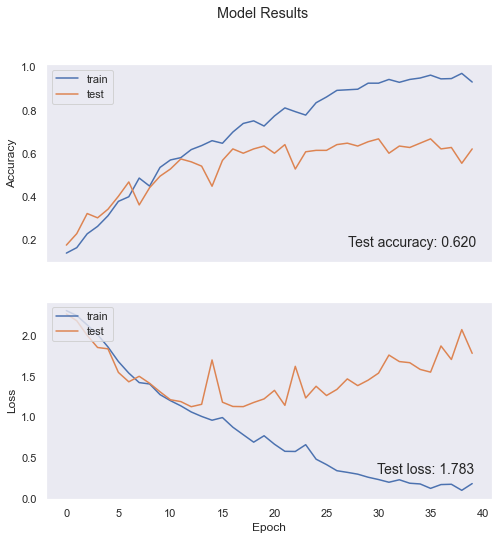

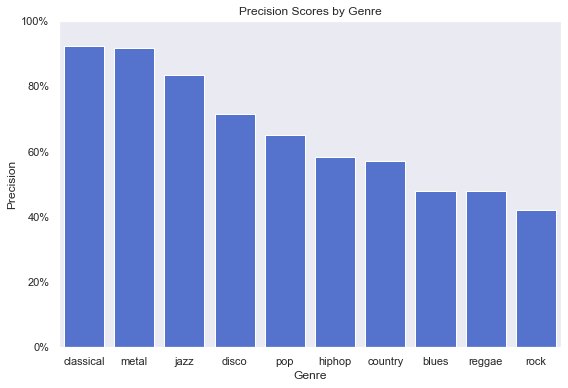

In [263]:
# visualize results and return predictions
cnn_results = evaluate(cnn, history, X_test_mel_scaled, y_test, labels)

This first cnn does achieve a higher accuracy score on the test set. However, there are more clear signs of overfitting. To mitigate this, we will apply some regularization via dropout layers in the fully-connected classifier portion. We will also use early stopping to help unnecessary training when the model appears to be overfitting.

In [316]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn = keras.Sequential(name='cnn_2')

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 4)))

cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))

cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.3))

# output layer
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 1249, 16)     160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 312, 16)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 312, 32)       4640      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 78, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 39, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 39, 128)       73856 

In [317]:
# define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_cnn2.h5', monitor='val_loss', save_best_only=True)]

# fit the model
history = cnn.fit(X_train_mel_scaled,
                  y_train,
                  epochs=60,
                  batch_size=30,
                  callbacks=early_stopping,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/60
25/25 [==============================] - 18s 717ms/step - loss: 2.3072 - accuracy: 0.1095 - val_loss: 2.2889 - val_accuracy: 0.1000
Epoch 2/60
25/25 [==============================] - 18s 726ms/step - loss: 2.2825 - accuracy: 0.1362 - val_loss: 2.2577 - val_accuracy: 0.2000
Epoch 3/60
25/25 [==============================] - 19s 771ms/step - loss: 2.2278 - accuracy: 0.1642 - val_loss: 2.1842 - val_accuracy: 0.2133
Epoch 4/60
25/25 [==============================] - 20s 820ms/step - loss: 2.1631 - accuracy: 0.1949 - val_loss: 2.0590 - val_accuracy: 0.2267
Epoch 5/60
25/25 [==============================] - 19s 763ms/step - loss: 2.1250 - accuracy: 0.2109 - val_loss: 2.1221 - val_accuracy: 0.2467
Epoch 6/60
25/25 [==============================] - 20s 780ms/step - loss: 2.0602 - accuracy: 0.2510 - val_loss: 1.8871 - val_accuracy: 0.3133
Epoch 7/60
25/25 [==============================] - 19s 769ms/step - loss: 1.9705 - accuracy: 0.2430 - val_loss: 1.8882 - val_accuracy: 0.3000

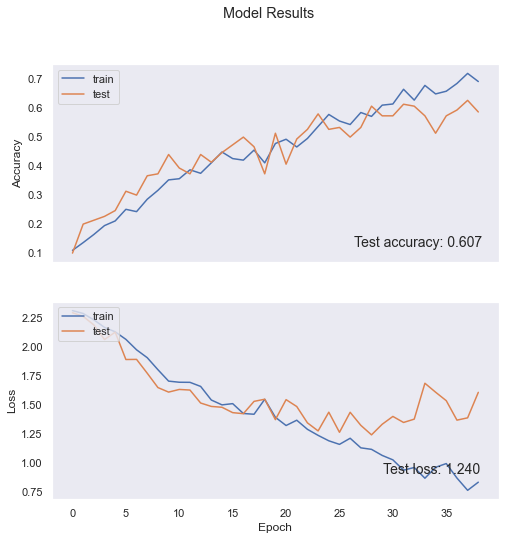

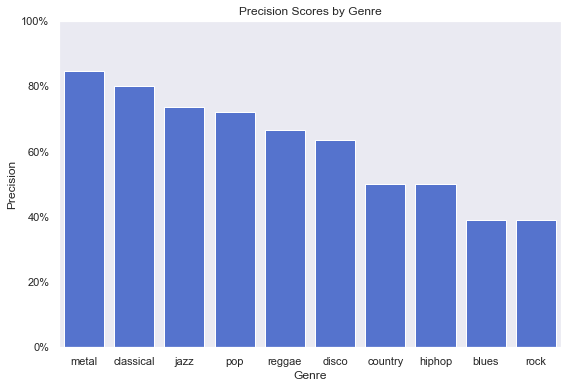

In [318]:
# load saved model
saved_cnn = load_model('best_cnn2.h5')

# visualize results and return predictions
cnn_results = evaluate(saved_cnn, history, X_test_mel_scaled, y_test, labels)

The best model from this run achievs 61% test accuracy, while not showing as much signs of overfitting. After training for 39 epochs, the training was stopped. 

# CNN Model with MFCC's


In [43]:
def prepare_dataset(test_size, validation_size):
    X, y = load_data(r"/Users/stephen/Flatiron/Phase4/MIR/notebooks/stephen/data.mfcc.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [44]:
# split the data, changed varriable names to avoid conflicts


input_train, input_val, input_test, target_train, target_val, target_test = prepare_dataset(0.25, 0.2)

In [45]:
# find input shape for CNN 
input_shape = (input_train.shape[1],input_train.shape[2],input_train.shape[3])
print(input_shape)

(130, 20, 1)


In [50]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 18, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 9, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 9, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 7, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 4, 32)        0         
 2D)                                                             
                                                      

In [53]:
adam = optimizers.Adam(learning_rate=1e-4)

In [55]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_val, target_val),
                 epochs = 60,
                 batch_size = 32)

Epoch 1/60
188/188 [==============================] - 18s 90ms/step - loss: 2.6560 - accuracy: 0.1491 - val_loss: 2.0379 - val_accuracy: 0.2911
Epoch 2/60
188/188 [==============================] - 16s 88ms/step - loss: 2.1512 - accuracy: 0.2537 - val_loss: 1.7873 - val_accuracy: 0.3438
Epoch 3/60
188/188 [==============================] - 17s 90ms/step - loss: 1.9073 - accuracy: 0.3262 - val_loss: 1.6231 - val_accuracy: 0.4072
Epoch 4/60
188/188 [==============================] - 15s 80ms/step - loss: 1.7672 - accuracy: 0.3714 - val_loss: 1.5286 - val_accuracy: 0.4312
Epoch 5/60
188/188 [==============================] - 16s 85ms/step - loss: 1.6587 - accuracy: 0.3941 - val_loss: 1.4436 - val_accuracy: 0.4573
Epoch 6/60
188/188 [==============================] - 19s 99ms/step - loss: 1.5711 - accuracy: 0.4245 - val_loss: 1.3695 - val_accuracy: 0.4973
Epoch 7/60
188/188 [==============================] - 16s 84ms/step - loss: 1.5007 - accuracy: 0.4580 - val_loss: 1.3197 - val_accuracy:

In [56]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 1440x1080 with 0 Axes>

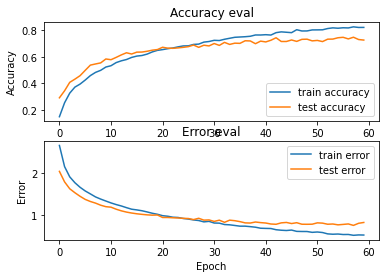

In [57]:
plot_history(hist)

In [58]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 2s 22ms/step - loss: 0.8415 - accuracy: 0.7309
Test accuracy: 0.7308770418167114


### Final Model

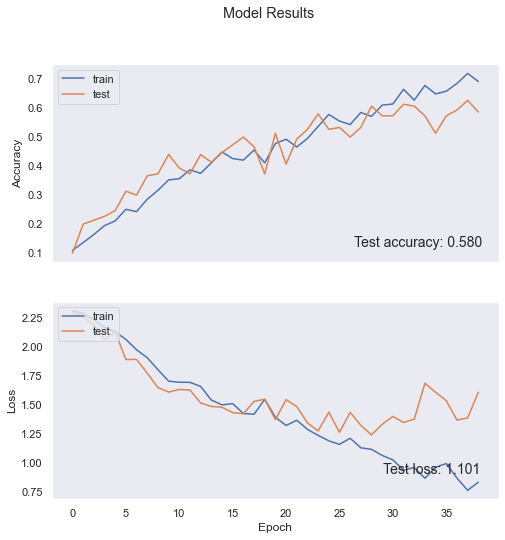

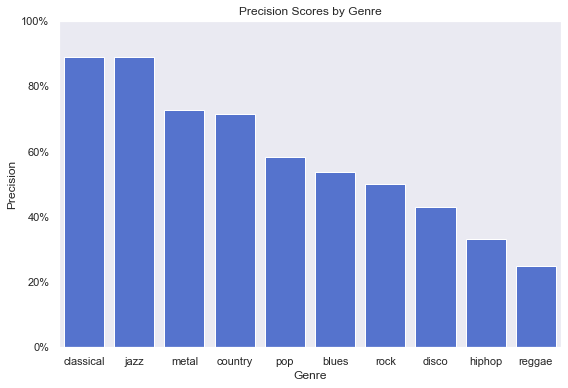

In [319]:
# visualize results and return predictions
cnn_results = evaluate(saved_cnn, history, X_hold_mel_scaled, y_hold, labels)

Here we see the CNN trained on mel spectrograms, our final model, has achieved a 58% accuracy score on the holdout set. This model predicts some genres, like classical and jazz, with high precision. When it makes this genre prediction, it is frequently correct. Other genres, like hip hop and reggae, are predicted with low precision.

In [352]:
# precision score data
cnn_results[1]

Precision
classical   0.888889
jazz        0.888889
metal       0.727273
country     0.714286
pop         0.583333
blues       0.538462
rock        0.500000
disco       0.428571
hiphop      0.333333
reggae      0.250000

To better understand where the model is wrong, below is the confusion matrix.

In [320]:
# confusion matrix
confusion = pd.DataFrame(confusion_matrix(np.argmax(y_hold, 1), np.argmax(cnn_results[0], 1)),
                         index=labels,
                         columns=labels)

confusion

blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
blues          7          0        0      0       0     0      0    0       0   
classical      0          8        1      0       0     1      0    0       0   
country        2          1        5      1       0     0      0    0       0   
disco          0          0        0      3       2     0      1    3       0   
hiphop         0          0        0      0       2     0      1    1       6   
jazz           1          0        1      0       0     8      0    0       0   
metal          0          0        0      0       0     0      8    0       0   
pop            0          0        0      0       1     0      0    7       2   
reggae         3          0        0      2       1     0      0    1       3   
rock           0          0        0      1       0     0      1    0       1   

           rock  
blues         3  
classical     0  
country       1  
disco         1  
hiphop        0  
jazz          0  
metal         2  
pop           0  
reggae        0  
rock          7

Specifically for the two worst performing genres, hip hop and reggae, let's visualize their misclassifications. Below are the actual genres when the model predicts these two.

In [327]:
# reggae predictions
reggae_preds = confusion.sort_values('reggae', ascending=False)['reggae']/confusion['reggae'].sum()
reggae_preds = reggae_preds[reggae_preds>0]

# hip hop predictions
hiphop_preds = confusion.sort_values('hiphop', ascending=False)['hiphop']/confusion['hiphop'].sum()
hiphop_preds = hiphop_preds[hiphop_preds>0]

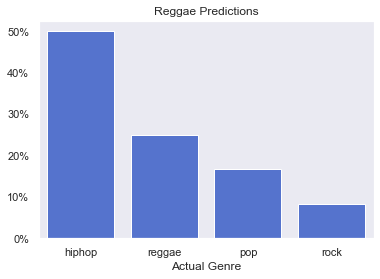

In [331]:
# reggae predictions bar plot
fig, ax = plt.subplots()

reggae = sns.barplot(x=reggae_preds.index,
                    y=reggae_preds,
                    ax=ax,
                    color='royalblue')

# Customize asthetic
ax.grid(False) # Show the vertical gridlines
reggae.set_title("Reggae Predictions")
reggae.set_xlabel('Actual Genre')
reggae.set_ylabel('')
reggae.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

# set yticklabels to be a %
yticklabels = [f'{tick *100:.0f}%' for tick in reggae.get_yticks()]
reggae.set_yticklabels(yticklabels);

When the model predicts reggae, 50% of the time on the holdout set, it's actually hip hop.

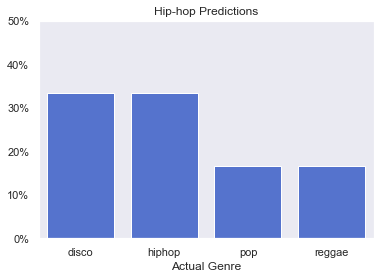

In [332]:
# hiphop predictions bar plot
fig, ax = plt.subplots()

hiphop = sns.barplot(x=hiphop_preds.index,
                    y=hiphop_preds,
                    ax=ax,
                    color='royalblue')

# Customize asthetic
ax.grid(False) # Show the vertical gridlines
hiphop.set_title("Hip-hop Predictions")
hiphop.set_xlabel('Actual Genre')
hiphop.set_ylabel('')
hiphop.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

# set yticklabels to be a %
yticklabels = [f'{tick *100:.0f}%' for tick in hiphop.get_yticks()]
hiphop.set_yticklabels(yticklabels);

We will also listen to a few examples of misclassifications below.

In [323]:
# map genre to ohe label
genre_dict = {ind:genre for ind, genre in enumerate(labels)}

# make dataframe of targets and predictions
preds_df = pd.DataFrame(np.concatenate([np.argmax(y_hold, 1).reshape(-1, 1),
                                        np.argmax(cnn_results[0], 1).reshape(-1, 1)], axis=1),
                        index=X_hold.index,
                        columns=['y', 'preds'])

# add song file paths
preds_df['file_path'] = X_hold

# map ohe labels to genres
preds_df['y'] = preds_df['y'].map(genre_dict)
preds_df['preds'] = preds_df['preds'].map(genre_dict)
preds_df.head()

y  preds                                     file_path
692   metal   rock    Data/genres_original/metal/metal.00092.wav
516    jazz   jazz      Data/genres_original/jazz/jazz.00016.wav
806  reggae  blues  Data/genres_original/reggae/reggae.00006.wav
921    rock   rock      Data/genres_original/rock/rock.00021.wav
63    blues  blues    Data/genres_original/blues/blues.00063.wav

In [359]:
# predicted hiphop
preds_df[preds_df['preds'] == 'hiphop']

y   preds                                     file_path
489  hiphop  hiphop  Data/genres_original/hiphop/hiphop.00089.wav
789     pop  hiphop        Data/genres_original/pop/pop.00089.wav
406  hiphop  hiphop  Data/genres_original/hiphop/hiphop.00006.wav
353   disco  hiphop    Data/genres_original/disco/disco.00053.wav
899  reggae  hiphop  Data/genres_original/reggae/reggae.00099.wav
390   disco  hiphop    Data/genres_original/disco/disco.00090.wav

In [370]:
# pop misclassified as hiphop
y, sr = librosa.load(preds_df['file_path'][789], duration=30)
ipd.Audio(y, rate=sr)

In [367]:
# disco misclassified as hiphop
y, sr = librosa.load(preds_df['file_path'][353], duration=30)
ipd.Audio(y, rate=sr)

In [365]:
# reggae misclassified as hiphop
y, sr = librosa.load(preds_df['file_path'][899], duration=30)
ipd.Audio(y, rate=sr)

## Conclusions

We recommend that the model be used to make predictions for label genre for songs. While 58% accuracy and some low precision scores for some genres may be cause for hesitance, the application of these labels mitigates the issue. In creating playlists, we generally want to include songs that are similar to one another, but possibly different enough to be intriguing. The model's misclassifications could be viewed in a positive light this way. They are better than a 10% base rate, but may provide enough variation to be helpful.

A limitation of the model is the genres themselves are inherently subjective. Also, the data contains merely 10 genres and 1000 songs. Gathering more examples of even more genres could be highly effective in training a model.

We would also like to consider other audio features in constructing a model. In addition to mel spectrograms and MFCCs, we could look at chromagrams or recurrence plots for input. Tabular data such as tempo could also be incorporated into a multi-input model.